In [89]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.basic_cleaning import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [90]:
train_data = pl.read_csv("balanced_train.csv")
test_data = pl.read_csv("balanced_test.csv")
train_data

SeniorCitizen,tenure,MultipleLines,InternetService,TechSupport,Contract,MonthlyCharges,TotalCharges,Streamer,Safer,Family,OnlinePayment,MonthlyChargesBin,Churn
i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64
0,51,0,1,1,12,60.15,3077.0,1,1,0,0,0,0
0,5,0,2,0,12,20.1,85.1,0,0,1,0,0,0
0,28,0,0,0,1,81.05,2227.1,1,0,1,1,1,1
0,2,0,0,0,1,79.75,164.5,1,0,0,1,1,1
0,30,1,0,0,1,94.3,2679.7,1,1,0,0,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,23,1,0,0,1,89.95,2483.5,1,1,0,1,1,1
0,69,0,0,1,12,104.05,4822.85,1,1,0,0,1,1
0,44,1,0,0,1,80.0,3862.55,0,1,0,0,1,1


In [91]:
# ratio=len(train_data.filter(train_data["Churn"]==1))/(len(train_data))
# ratio

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder

cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

import joblib
with open("pipe_smote.joblib",'rb'):
    pipe=joblib.load("pipe_smote.joblib")
pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'TechSupport', 'Contract',
                                                   'MonthlyCharges',
                                                   'TotalCharges', 'Streamer',
                                                   'Safer', 'Family',
                                                   'OnlinePayment',
                                                   'MonthlyChargesBin'])])),
                ('classifier',
                 LogisticRegression(C=84.93232352269546, penalty='l1',
                                    random_state=42, solver='liblinear'))])

Mean Train roc auc Score: 0.8737916178855513
Mean Train recall Score: 0.8008053897594195

Mean Test roc auc Score: 0.8727104833211876
Mean Test recall Score: 0.7996364512564941
Recall score: 0.84
Correlation : 0.6423855024126721
Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      1031
           1       0.81      0.84      0.82      1031

    accuracy                           0.82      2062
   macro avg       0.82      0.82      0.82      2062
weighted avg       0.82      0.82      0.82      2062



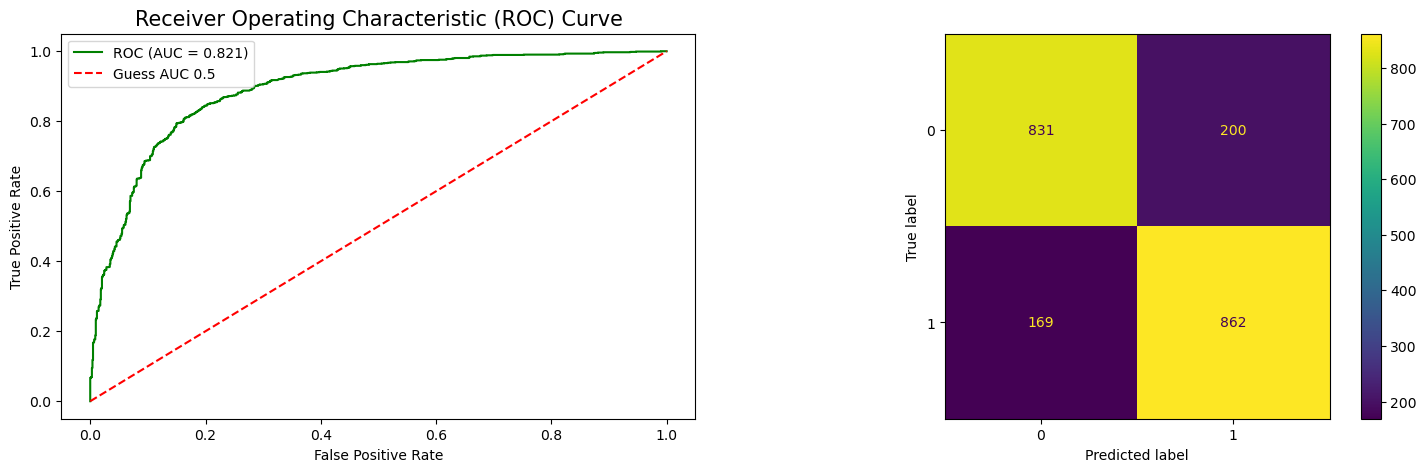

In [93]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,recall_score,matthews_corrcoef
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=42)
pipe.fit(X_train, y_train)

# Evaluation

cv_results = cross_validate(pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=10,random_state=42)

cv_results = cross_validate(pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score,recall_score
from sklearn.model_selection import cross_val_predict
# Evaluation
predictions_prob= cross_val_predict(pipe,X_test,y_test,method='predict_proba',n_jobs=-1)
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation : {coef}")
print("\033[4mClassification Report\033[0m \n",classification_report(y_test,predictions))
fpr, tpr, thresholds=roc_curve(y_test,predictions_prob[:,1])
plot_evaluation(fpr, tpr,y_test,predictions,roc_auc)

In [94]:
if hasattr(pipe.named_steps['classifier'], 'coef_'):
    feature_importances = pipe.named_steps['classifier'].coef_[0]
    feature_names = get_features(pipe.named_steps['transformer'])
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(importance_df)

              Feature  Importance
7        TotalCharges    1.259119
8            Streamer    0.529583
2       MultipleLines    0.246909
12  MonthlyChargesBin    0.201679
11      OnlinePayment    0.177146
9               Safer    0.045593
0       SeniorCitizen    0.013417
4         TechSupport   -0.022759
10             Family   -0.139592
5            Contract   -0.305824
3     InternetService   -1.854802
6      MonthlyCharges   -1.939965
1              tenure   -2.168474


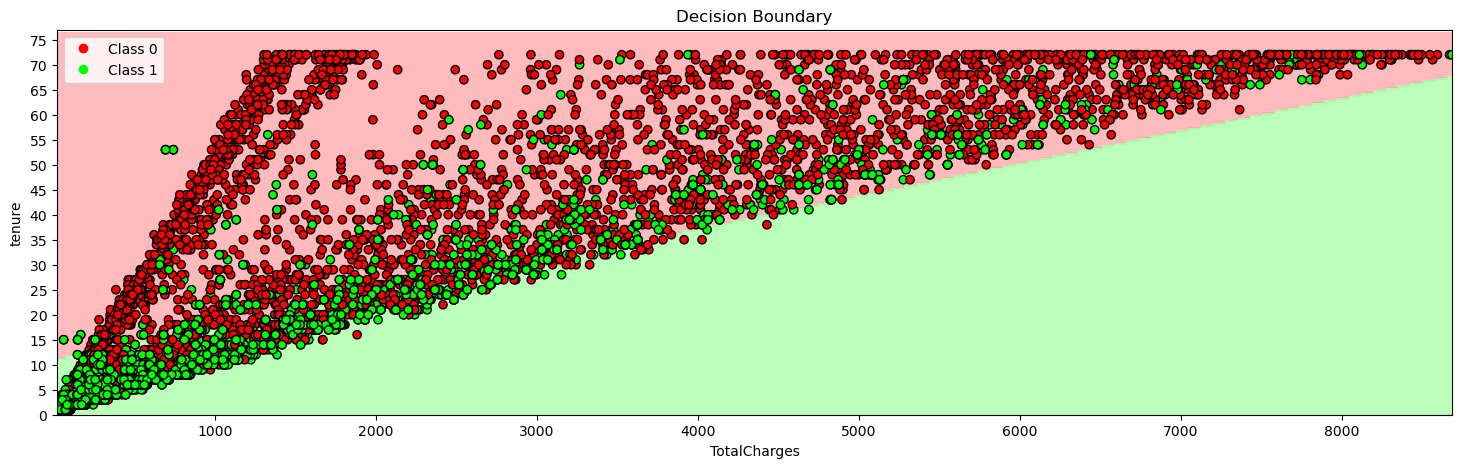

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

# Assuming pipe is your pipeline and transformer is part of it
transformer = pipe.named_steps['transformer']
classifier = pipe.named_steps['classifier']

# Select two features (example: 'MonthlyCharges' and 'Contract')
feature1 = 'TotalCharges'
feature2 = 'tenure'

# Create a mesh grid
h = .5  # step size in the mesh
x_min, x_max = X_train[feature1].min() - 1, X_train[feature1].max() + 1
y_min, y_max = X_train[feature2].min() - 1, X_train[feature2].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Prepare the data for the prediction on the mesh grid
grid_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feature1, feature2])

# Add other features with default values to match the original dataset
for col in X_train.columns:
    if col not in [feature1, feature2]:
        grid_data[col] = X_train[col].mean()  # or some default value

# Apply the same transformations to the grid data
grid_data_transformed = transformer.transform(grid_data)

# Predict the classes for each point in the mesh grid
Z = classifier.predict(grid_data_transformed)
Z = Z.reshape(xx.shape)

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ['#FF0000', '#00FF00']

plt.figure(figsize=(18, 5))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)

# Plot the training points
scatter = plt.scatter(X_train[feature1], X_train[feature2], c=y_train, edgecolors='k', marker='o', cmap=ListedColormap(cmap_bold))

# Adjust y-axis limits
plt.ylim(y_min, y_max)

# Add more tick labels
plt.yticks(np.arange(y_min, y_max + 1, 5))  # Adjust the increment as needed

# Label the y-axis
plt.ylabel(feature2)

plt.xlabel(feature1)
plt.title('Decision Boundary')

# Create a legend
handles = scatter.legend_elements()[0]
labels = ['Class 0', 'Class 1']
plt.legend(handles, labels)

plt.show()

In [96]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_pipe = Pipeline(
    [
        ("transformer", transformer),
        ("classifier", LinearDiscriminantAnalysis()),
    ]
)
lda_pipe.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'TechSupport', 'Contract',
                                                   'MonthlyCharges',
                                                   'TotalCharges', 'Streamer',
                                                   'Safer', 'Family',
                                                   'OnlinePayment',
                                                   'MonthlyChargesBin'])])),
                ('classifier', LinearDiscriminantAnalysis())])

Best Parameters: OrderedDict([('classifier__shrinkage', None), ('classifier__solver', 'lsqr')])
Mean Train roc auc Score: 0.8695131460055097
Mean Train recall Score: 0.8077171717171717

Mean Test roc auc Score: 0.8683683673094582
Mean Test recall Score: 0.8073535353535354
Recall score: 0.85
Correlation : 0.6353768202442576
Classification Report 
               precision    recall  f1-score   support

           0       0.84      0.79      0.81      1031
           1       0.80      0.85      0.82      1031

    accuracy                           0.82      2062
   macro avg       0.82      0.82      0.82      2062
weighted avg       0.82      0.82      0.82      2062



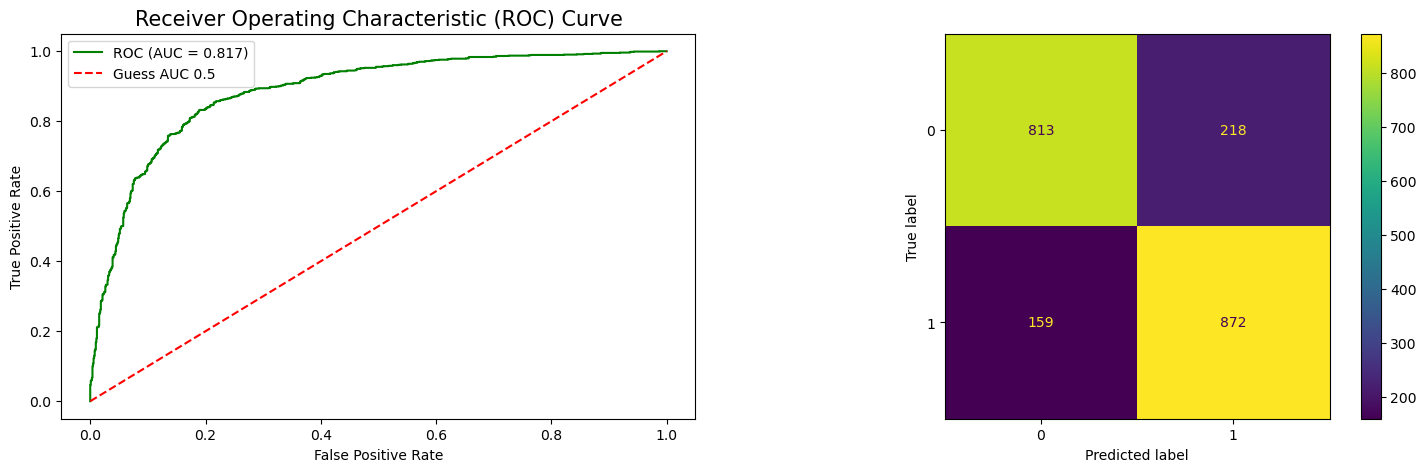

In [97]:
from skopt import BayesSearchCV
from skopt.space import Categorical
# Define the hyperparameter search space for LDA
param_distributions = {
    'classifier__solver': Categorical(['lsqr', 'eigen']),
    'classifier__shrinkage': Categorical(['auto', None, 0.1, 0.5, 0.9])
}

# Define the pipeline
pipe_lda = Pipeline([
    ("transformer", transformer),
    ("classifier", LinearDiscriminantAnalysis())
])

# Define the cross-validation strategy
rskf = RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=42)

# Define the BayesSearchCV
search = BayesSearchCV(
    estimator=pipe_lda,
    search_spaces=param_distributions,
    n_iter=20,
    cv=rskf,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit the model
# search.fit(X_train, y_train)

# Get the best parameters
# best_params = search.best_params_
# print(f"Best Parameters: {best_params}")

# # Fit the best model
# pipe_lda.set_params(**best_params)
pipe_lda.fit(X_train, y_train)
# Evaluation

cv_results = cross_validate(lda_pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=42)

cv_results = cross_validate(lda_pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score,recall_score
from sklearn.model_selection import cross_val_predict
# Evaluation
predictions_prob= cross_val_predict(lda_pipe,X_test,y_test,method='predict_proba',n_jobs=-1)
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation : {coef}")
print("\033[4mClassification Report\033[0m \n",classification_report(y_test,predictions))
fpr, tpr, thresholds=roc_curve(y_test,predictions_prob[:,1])
plot_evaluation(fpr, tpr,y_test,predictions,roc_auc)

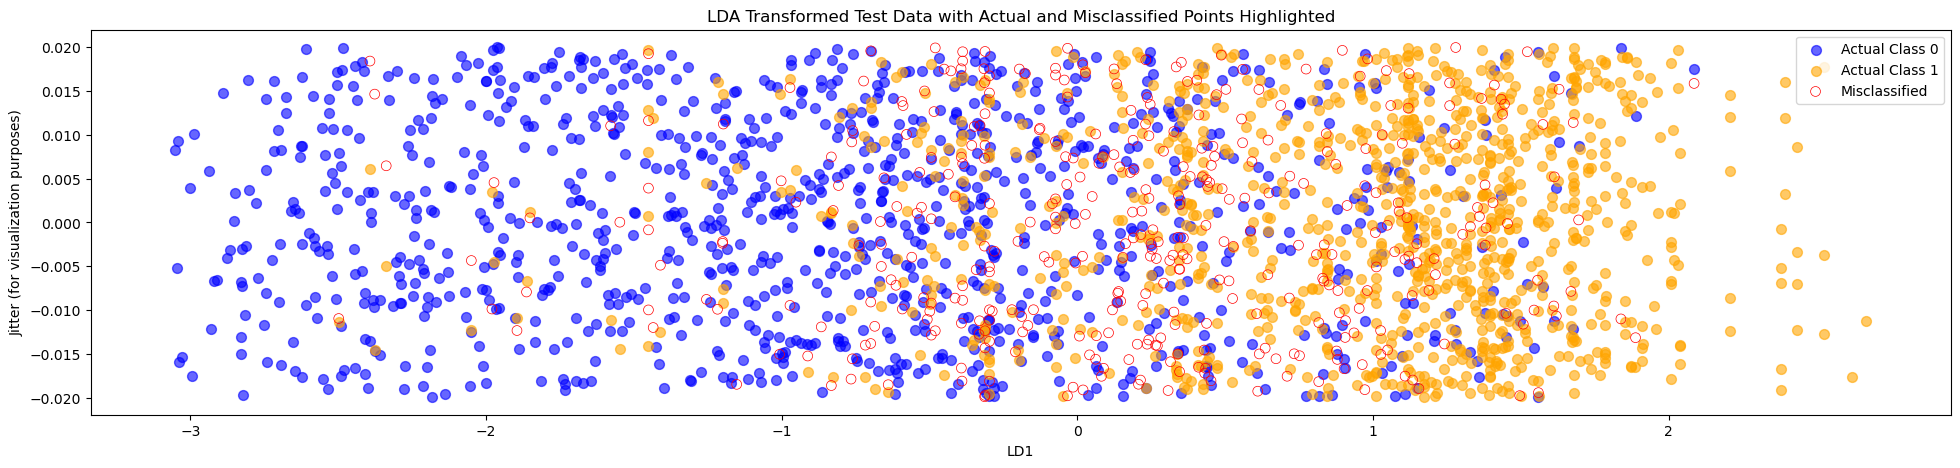

In [98]:
X_train_lda=lda_pipe.transform(X_train)
X_test_lda=lda_pipe.transform(X_test)
# Creating the plot
plt.figure(figsize=(24, 5))
point_size = 50  # Adjust point size as needed
jitter = 0.02  # Adjust jitter as needed

for actual_class in [0, 1]:
    idx = (y_test == actual_class)
    jitter_values = np.random.uniform(-jitter, jitter, size=idx.sum())
    plt.scatter(X_test_lda[idx], jitter_values, 
                c='blue' if actual_class == 0 else 'orange', 
                label=f'Actual Class {actual_class}', alpha=0.6, s=point_size)

# Highlight misclassified points
misclassified_idx = (predictions != y_test)
misclassified_jitter = np.random.uniform(-jitter, jitter, size=misclassified_idx.sum())
plt.scatter(X_test_lda[misclassified_idx], misclassified_jitter, 
            facecolors='none', edgecolors='red', linewidths=0.5, label='Misclassified', s=point_size)

plt.title('LDA Transformed Test Data with Actual and Misclassified Points Highlighted')
plt.xlabel('LD1')
plt.ylabel('Jitter (for visualization purposes)')
plt.legend()
# plt.grid(axis='x')
plt.show()

In [99]:
lda_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'TechSupport', 'Contract',
                                                   'MonthlyCharges',
                                                   'TotalCharges', 'Streamer',
                                                   'Safer', 'Family',
                                                   'OnlinePayment',
                                                   'MonthlyChargesBin'])])),
                ('classifier', LinearDiscriminantAnalysis())])